# Import

In [33]:
import os
import pathlib
import tensorflow as tf
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

# Functions

In [79]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [80]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
def generate_image(data_dir, aug_type, aug_func, aug_params, resize=False):
    sample_shown = False
    for class_name in CLASS_NAMES:
        images_path = list(data_dir.glob(class_name+'/*.png'))
        
        for image in images_path:
            try:
                img_name = str(image).split('/')[-1]
                img = tf.io.read_file(str(image))
                # Copy image to augmented directory
                fname = tf.constant('Augmented_Dataset/'+aug_type+'/'+class_name+'/'+img_name)
                fwrite = tf.io.write_file(fname, img)

                # Flip image and save
                img = tf.image.decode_png(img, channels=3)
                aug_img = aug_func(img, *aug_params)
                if sample_shown == False:
                    visualize(img, aug_img)
                    sample_shown = True
                # if resize:
                #     aug_img = tf.image.convert_image_dtype(aug_img, tf.float32)
                #     aug_img = tf.image.resize(aug_img, [IMG_WIDTH, IMG_HEIGHT])
                enc = tf.image.encode_png(aug_img)
                fname = tf.constant('Augmented_Dataset/'+aug_type+'/'+class_name+'/'+aug_type+'_'+img_name)
                fwrite = tf.io.write_file(fname, enc)
                
            except Exception as error:
                print(error)
                continue

# Create Directories

In [ ]:
CLASS_NAMES = ['Density4Benign', 'Density1Benign', 'Density3Malignant', 'Density3Benign', 'Density4Malignant', 'Density2Benign', 'Density1Malignant', 'Density2Malignant']

augmentation_type = ['crop', 'vertical_flip', 'horizontal_flip', 'brightness']

In [51]:
def create_class_dir(aug_type):
    for class_name in CLASS_NAMES:
        try:
            os.mkdir(os.path.join('.','Augmented_Dataset/'+aug_type+'/'+class_name))
            print(class_name," directory created")
        except FileExistsError as error:
            print(error)
            continue

In [82]:
try:
    # Create Augmented Dataset directory
    path = os.path.join('.', 'Augmented_Dataset/')
    os.mkdir(path)
    print("Augmented_Dataset directory created")
except FileExistsError as error:
    print(error)

# Create subdirectories
for aug_type in augmentation_type:
    try:
        os.mkdir(os.path.join('.','Augmented_Dataset/'+aug_type))
        print(aug_type," directory created")
        create_class_dir(aug_type)        
    except FileExistsError as error:
        print(error)
        create_class_dir(aug_type)
        continue

[Errno 17] File exists: './Augmented_Dataset/'
[Errno 17] File exists: './Augmented_Dataset/crop'
[Errno 17] File exists: './Augmented_Dataset/crop/Density4Benign'
[Errno 17] File exists: './Augmented_Dataset/crop/Density1Benign'
[Errno 17] File exists: './Augmented_Dataset/crop/Density3Malignant'
[Errno 17] File exists: './Augmented_Dataset/crop/Density3Benign'
[Errno 17] File exists: './Augmented_Dataset/crop/Density4Malignant'
[Errno 17] File exists: './Augmented_Dataset/crop/Density2Benign'
[Errno 17] File exists: './Augmented_Dataset/crop/Density1Malignant'
[Errno 17] File exists: './Augmented_Dataset/crop/Density2Malignant'
vertical_flip  directory created
Density4Benign  directory created
Density1Benign  directory created
Density3Malignant  directory created
Density3Benign  directory created
Density4Malignant  directory created
Density2Benign  directory created
Density1Malignant  directory created
Density2Malignant  directory created
horizontal_flip  directory created
Density4Be

In [ ]:
data_dir = './Dataset'
data_dir = pathlib.Path(data_dir)

# Generate and save vertical flip images

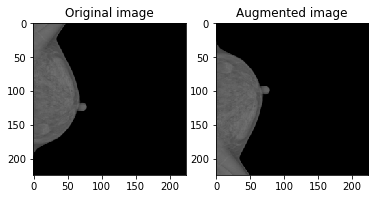

In [83]:
generate_image(data_dir, 'vertical_flip', tf.image.flip_up_down, [])

# Generate and save horizontal flip images

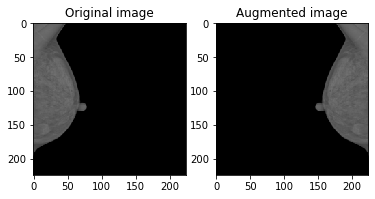

In [84]:
generate_image(data_dir, 'horizontal_flip', tf.image.flip_left_right, [])

# Random crop

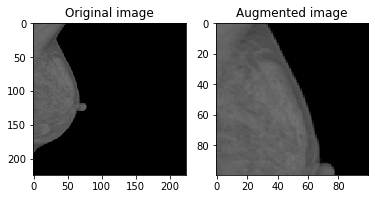

In [81]:
generate_image(data_dir, 'crop', tf.image.random_crop, [(100,100,3)], resize=True)